
$ \newcommand{\Bra}[1]{\left\langle #1 \right|} $
$ \newcommand{\Ket}[1]{\left| #1 \right\rangle} $

# Nuclear Spin Hamiltonian: Zeeman Basis V2 (inverted alpha)

In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as e_charge
from scipy.constants import hbar, mega
from scipy.optimize import fsolve
import sympy as sp
from sympy.physics.matrices import msigma

import nmrlib.core as nmr
import nmrlib.quantum as quant
from src import ROOT
from src.utils import find_max_min

FIGSIZE = mpl.rcParams["figure.figsize"]

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)
        
def eig_sort(E, V):
    idx = E.argsort()[::-1]   
    return E[idx], V[:,idx]

## Eigenstates and eigenenergies

The first step is to find the states and energies. We first define the spin operators.

In [3]:
I = sp.Rational(3, 2)
sym = Bunch({})
sym.I = {}
sym.I['y'] = sp.Matrix([[0, -sp.I*sp.sqrt(3), 0, 0], [sp.I*sp.sqrt(3), 0, -sp.I*2, 0], [0, sp.I*2, 0, -sp.I*sp.sqrt(3)], [0, 0, sp.I*sp.sqrt(3), 0]])/2
sym.I['x'] = sp.Matrix([[0, sp.sqrt(3), 0, 0], [sp.sqrt(3), 0, 2, 0], [0, 2, 0, sp.sqrt(3)], [0, 0, sp.sqrt(3), 0]])/2
sym.I['z'] = sp.Matrix([[I, 0, 0, 0], [0, I - 1, 0, 0], [0, 0, I - 2, 0], [0, 0, 0, I - 3]])
for i in ['x', 'y', 'z']:
    display(sym.I[i])

Matrix([
[        0, sqrt(3)/2,         0,         0],
[sqrt(3)/2,         0,         1,         0],
[        0,         1,         0, sqrt(3)/2],
[        0,         0, sqrt(3)/2,         0]])

Matrix([
[          0, -sqrt(3)*I/2,           0,            0],
[sqrt(3)*I/2,            0,          -I,            0],
[          0,            I,           0, -sqrt(3)*I/2],
[          0,            0, sqrt(3)*I/2,            0]])

Matrix([
[3/2,   0,    0,    0],
[  0, 1/2,    0,    0],
[  0,   0, -1/2,    0],
[  0,   0,    0, -3/2]])

It is easier to generate the Hamiltonian in the quadrupolar basis first.

In [4]:
sym.alpha, sym.delta = sp.symbols('alpha delta', real=True)#, positive=True)
sym.X = [None]*4
sym.Xp = [None]*4
sym.X[0] = sp.eye(4)[:, 0]
sym.X[1] = sp.eye(4)[:, 1]
sym.X[2] = sp.eye(4)[:, 2]
sym.X[3] = sp.eye(4)[:, 3]
sym.Xp[0] = sp.cos(sym.delta)*sym.X[0] + sp.sin(sym.delta)*sym.X[2]
sym.Xp[3] = sp.cos(sym.delta)*sym.X[3] + sp.sin(sym.delta)*sym.X[1]
sym.Xp[1] = sp.cos(sym.delta)*sym.X[1] - sp.sin(sym.delta)*sym.X[3]
sym.Xp[2] = sp.cos(sym.delta)*sym.X[2] - sp.sin(sym.delta)*sym.X[0]
for i in sym.Xp:
    display(i)
Hq = np.diag([1, -1, -1, 1]) # Quadrupolar Hamiltonian
Iz = sp.Matrix(np.zeros([4, 4], dtype=object)) # Iz
for i in range(4):
    for j in range(4):
        Iz[i, j] = sym.Xp[i].dot(sym.I['z']*sym.Xp[j])
TRIGSUBS = {sp.sin(sym.delta)**2: (1 - sp.cos(2*sym.delta))/2, sp.cos(sym.delta)**2: (sp.cos(2*sym.delta) + 1)/2}
Iz = sp.simplify(Iz).subs(TRIGSUBS)
display(Iz)
sym.H_qbasis = sp.simplify(sp.Matrix(Hq + sym.alpha*Iz))
sym.H_qbasis

Matrix([
[cos(delta)],
[         0],
[sin(delta)],
[         0]])

Matrix([
[          0],
[ cos(delta)],
[          0],
[-sin(delta)]])

Matrix([
[-sin(delta)],
[          0],
[ cos(delta)],
[          0]])

Matrix([
[         0],
[sin(delta)],
[         0],
[cos(delta)]])

Matrix([
[cos(2*delta) + 1/2,                  0,      -sin(2*delta),                   0],
[                 0, cos(2*delta) - 1/2,                  0,        sin(2*delta)],
[     -sin(2*delta),                  0, 1/2 - cos(2*delta),                   0],
[                 0,       sin(2*delta),                  0, -cos(2*delta) - 1/2]])

Matrix([
[alpha*cos(2*delta) + alpha/2 + 1,                                0,               -alpha*sin(2*delta),                                 0],
[                               0, alpha*cos(2*delta) - alpha/2 - 1,                                 0,                alpha*sin(2*delta)],
[             -alpha*sin(2*delta),                                0, -alpha*cos(2*delta) + alpha/2 - 1,                                 0],
[                               0,               alpha*sin(2*delta),                                 0, -alpha*cos(2*delta) - alpha/2 + 1]])

Now change to $ m $-basis by a unitary operator $ U = \sum_k \Ket{b^{(k)}} \Bra{a^{(k)}} $ (assuming going from $ A $ basis to $ B $ basis).

In [5]:
sym.U = sp.zeros(4, 4)
for k in range(4):
    bk = sym.X[k]
    ak = sym.Xp[k]
    sym.U += bk*ak.T
sym.U

Matrix([
[ cos(delta),          0, sin(delta),           0],
[          0, cos(delta),          0, -sin(delta)],
[-sin(delta),          0, cos(delta),           0],
[          0, sin(delta),          0,  cos(delta)]])

The Hamiltonian in the $ m $-basis is then $ U^\dagger H U $, with the following eigenenergies.

In [6]:
sym.H_mbasis = sp.simplify((sym.U.T*sym.H_qbasis*sym.U))
display(sym.H_mbasis)

a, b, c = sp.symbols('a b c')
H_temp = sp.Matrix([[3*a + b, 0, c, 0], [0, a - b, 0, c], [c, 0, -a - b, 0], [0, c, 0, -3*a + b]])
eigvals_temp = list(H_temp.eigenvals())
display(H_temp)

subs = {a: sym.alpha/2, b: sp.cos(2*sym.delta), c: sp.sin(2*sym.delta)}
for i in range(4):
    E = sp.simplify(sp.simplify(eigvals_temp[i].subs(subs)).subs(TRIGSUBS))
    display(E)

Matrix([
[3*alpha/2 + cos(2*delta),                      0,            sin(2*delta),                         0],
[                       0, alpha/2 - cos(2*delta),                       0,              sin(2*delta)],
[            sin(2*delta),                      0, -alpha/2 - cos(2*delta),                         0],
[                       0,           sin(2*delta),                       0, -3*alpha/2 + cos(2*delta)]])

Matrix([
[3*a + b,     0,      c,        0],
[      0, a - b,      0,        c],
[      c,     0, -a - b,        0],
[      0,     c,      0, -3*a + b]])

-alpha/2 - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

-alpha/2 + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

alpha/2 - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

alpha/2 + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

The eigenvectors are found manually (see paper I wrote for PHYS 784). In summary, the Hamiltonian and eigenstates are written below in the $ m $-basis along with the associated eigenenergies.

In [7]:
# sym.betap, sym.betam, sym.Ap, sym.Am, sym.D = sp.symbols('beta_+ beta_- A_+ A_- D')

# EVSUBS = {sym.betap: sym.alpha + sp.cos(2*sym.delta),
#           sym.betam: sym.alpha - sp.cos(2*sym.delta),
#           sym.Ap: 1/sp.sqrt(2*(sym.betap**2
#                                + sym.betap*sp.sqrt(sym.betap**2 + sp.sin(2*sym.delta)**2) + sp.sin(2*sym.delta)**2)),
#           sym.Am: 1/sp.sqrt(2*(sym.betam**2
#                                - sym.betam*sp.sqrt(sym.betam**2 + sp.sin(2*sym.delta)**2) + sp.sin(2*sym.delta)**2)),
#           sym.D: 2*sym.delta}
# sym.E = {}
# sym.V = {}
# sym.E[0] = sym.alpha/2 + sp.sqrt(sym.betap**2 + sp.sin(sym.D)**2)
# sym.V[0] = sym.Ap*((sym.betap + sp.sqrt(sym.betap**2 + sp.sin(sym.D)**2))*sym.X[0] + sp.sin(sym.D)*sym.X[2])
# sym.E[1] = -sym.alpha/2 - sp.sqrt(sym.betam**2 + sp.sin(sym.D)**2)
# sym.V[1] = sym.Am*((sym.betam - sp.sqrt(sym.betam**2 + sp.sin(sym.D)**2))*sym.X[1] + sp.sin(sym.D)*sym.X[3])
# sym.E[2] = sym.alpha/2 - sp.sqrt(sym.betap**2 + sp.sin(sym.D)**2)
# sym.V[2] = sym.Ap*((sym.betap + sp.sqrt(sym.betap**2 + sp.sin(sym.D)**2))*sym.X[2] - sp.sin(sym.D)*sym.X[0])
# sym.E[3] = -sym.alpha/2 + sp.sqrt(sym.betam**2 + sp.sin(sym.D)**2)
# sym.V[3] = sym.Am*((sym.betam - sp.sqrt(sym.betam**2 + sp.sin(sym.D)**2))*sym.X[3] - sp.sin(sym.D)*sym.X[1])

# for i in range(4):
#     display(sym.E[i], sym.V[i])

In [8]:
sym.beta, sym.Ap, sym.Am, sym.eta = sp.symbols('beta A_+ A_- eta')

EVSUBS = {sym.Ap: 1/sp.sqrt((sym.beta + 1 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3))**2 + sym.eta**2/3),
          sym.Am: 1/sp.sqrt((sym.beta - 1 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3))**2 + sym.eta**2/3)}
sym.E = {}
sym.V = {}
sym.E[0] = sym.beta/2 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3)
sym.V[0] = sym.Ap*((sym.beta + 1 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3))*sym.X[0]
                   + (sym.eta/sp.sqrt(3))*sym.X[2])
sym.E[1] = -sym.beta/2 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3)
sym.V[1] = sym.Am*((sym.beta - 1 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3))*sym.X[1]
                   + (sym.eta/sp.sqrt(3))*sym.X[3])
sym.E[2] = sym.beta/2 - sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3)
sym.V[2] = sym.Ap*((sym.beta + 1 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3))*sym.X[2]
                   - (sym.eta/sp.sqrt(3))*sym.X[0])
sym.E[3] = -sym.beta/2 + sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3)
sym.V[3] = sym.Am*((sym.beta - 1 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3))*sym.X[3]
                   - (sym.eta/sp.sqrt(3))*sym.X[1])
for i in range(4):
    display(sym.E[i], sym.V[i])

beta/2 + sqrt(eta**2/3 + (beta + 1)**2)

Matrix([
[A_+*(beta + sqrt(eta**2/3 + (beta + 1)**2) + 1)],
[                                              0],
[                              sqrt(3)*A_+*eta/3],
[                                              0]])

-beta/2 - sqrt(eta**2/3 + (beta - 1)**2)

Matrix([
[                                              0],
[A_-*(beta - sqrt(eta**2/3 + (beta - 1)**2) - 1)],
[                                              0],
[                              sqrt(3)*A_-*eta/3]])

beta/2 - sqrt(eta**2/3 + (beta + 1)**2)

Matrix([
[                             -sqrt(3)*A_+*eta/3],
[                                              0],
[A_+*(beta + sqrt(eta**2/3 + (beta + 1)**2) + 1)],
[                                              0]])

-beta/2 + sqrt(eta**2/3 + (beta - 1)**2)

Matrix([
[                                              0],
[                             -sqrt(3)*A_-*eta/3],
[                                              0],
[A_-*(beta - sqrt(eta**2/3 + (beta - 1)**2) - 1)]])

Now, we compare the analytical expressions to numerical evaluation.

In [9]:
# _eta, _rho = sp.symbols('eta rho')
# rho = sp.sqrt(1 + _eta**2/3)
# _H = sym.alpha*sym.I['z'] + 1/(3*rho)*(3*sym.I['z']**2 - (sym.I['x']**2 + sym.I['y']**2 + sym.I['z']**2)
#                                        + _eta*(sym.I['x']**2 - sym.I['y']**2))
# H_num = sp.simplify(_H.subs(_rho, rho).subs(_eta, sp.sqrt(3*(_rho**2 - 1))).subs(_rho, 1/sp.cos(2*sym.delta)))
# display(H_num)
# H_num_func = sp.lambdify([sym.alpha, sym.delta], H_num)
# H_func = sp.lambdify([sym.alpha, sym.delta], sym.H_mbasis)

# e = {}
# v = {}
# for i in range(4):
#     e[i] = sp.lambdify([sym.alpha, sym.delta], sym.E[i].subs(EVSUBS))
#     v[i] = sp.lambdify([sym.alpha, sym.delta], sym.V[i].subs(EVSUBS))

# alpha = np.linspace(0, 2)
# delta = np.pi/24
# for a in alpha:
#     _E_num, _V_num = np.linalg.eig(H_num_func(a, delta))
#     E_num, V_num = eig_sort(_E_num, _V_num)
    
#     _E = np.array([e[i](a, delta) for i in range(4)])
#     _V = np.array([v[i](a, delta).T for i in range(4)]).squeeze().T
#     #V = np.array([v1(a, delta).T, v2(a, delta).T, v3(a, delta).T, v4(a, delta).T]).squeeze().T
#     E, V = eig_sort(_E, _V)
#     for i in range(4):
#         check = np.matmul(H_func(a, delta), v[i](a, delta).squeeze()) - e[i](a, delta)*v[i](a, delta).squeeze()
#         if np.all(np.isclose(check, np.zeros(4))):
#             pass
#         else:
#             print('EV = EV not satisfied', check)
#         if np.all(np.isclose(V[:, i], V_num[:, i])) or np.all(np.isclose(-V[:, i], V_num[:, i])):
#             pass
#         else:
#             print('numerical and analytical solutions not matching up')
#             print('a = ', a)
#             print(E[i])
#             print(E_num[i])
#             print(V[:, i])
#             print(V_num[:, i])
        
    
#     print('='*80)

In [10]:
rho = sp.sqrt(1 + sym.eta**2/3)
sind = sp.sqrt((rho - 1)/(2*rho))
cosd = sp.sqrt((rho + 1)/(2*rho))
subs = {sym.alpha: sym.beta/rho,
        sp.sin(2*sym.delta): 2*sind*cosd,
        sp.cos(2*sym.delta): 1 - 2*sind**2}
_H = sym.beta*sym.I['z'] + sp.Rational(1, 3)*(3*sym.I['z']**2 - (sym.I['x']**2 + sym.I['y']**2 + sym.I['z']**2)
                                             + sym.eta*(sym.I['x']**2 - sym.I['y']**2))
H_num = sp.simplify(_H)
display(H_num)
H_num_func = sp.lambdify([sym.beta, sym.eta], H_num)
H = sp.simplify((rho*sym.H_mbasis).subs(subs))
H_func = sp.lambdify([sym.beta, sym.eta], H)
display(H)

e = {}
v = {}
for i in range(4):
    e[i] = sp.lambdify([sym.beta, sym.eta], sym.E[i].subs(EVSUBS))
    v[i] = sp.lambdify([sym.beta, sym.eta], sym.V[i].subs(EVSUBS))

beta = np.linspace(0, 2)
eta = 0.6
for b in beta:
    _E_num, _V_num = np.linalg.eig(H_num_func(b, eta))
    E_num, V_num = eig_sort(_E_num, _V_num)
    
    _E = np.array([e[i](b, eta) for i in range(4)])
    _V = np.array([v[i](b, eta).T for i in range(4)]).squeeze().T
    E, V = eig_sort(_E, _V)
    for i in range(4):
        check = np.matmul(H_func(b, eta), v[i](b, eta).squeeze()) - e[i](b, eta)*v[i](b, eta).squeeze()
        if np.all(np.isclose(check, np.zeros(4))):
            pass
        else:
            print('HV = EV not satisfied', check)

        if np.all(np.isclose(V[:, i], V_num[:, i])) or np.all(np.isclose(-V[:, i], V_num[:, i])):
            pass
        else:
            print('numerical and analytical solutions not matching up')
            print('b = ', b)
            print(E[i])
            print(E_num[i])
            print(V[:, i])
            print(V_num[:, i])
        
    print('='*80)

Matrix([
[ 3*beta/2 + 1,             0, sqrt(3)*eta/3,             0],
[            0,    beta/2 - 1,             0, sqrt(3)*eta/3],
[sqrt(3)*eta/3,             0,   -beta/2 - 1,             0],
[            0, sqrt(3)*eta/3,             0,  1 - 3*beta/2]])

Matrix([
[                                                                            3*beta/2 + 1,                                                                                        0, sqrt(sqrt(3) - 3/sqrt(eta**2 + 3))*sqrt(sqrt(3) + 3/sqrt(eta**2 + 3))*sqrt(eta**2 + 3)/3,                                                                                        0],
[                                                                                       0,                                                                               beta/2 - 1,                                                                                        0, sqrt(sqrt(3) - 3/sqrt(eta**2 + 3))*sqrt(sqrt(3) + 3/sqrt(eta**2 + 3))*sqrt(eta**2 + 3)/3],
[sqrt(sqrt(3) - 3/sqrt(eta**2 + 3))*sqrt(sqrt(3) + 3/sqrt(eta**2 + 3))*sqrt(eta**2 + 3)/3,                                                                                        0,                                                                              -beta/2 -

numerical and analytical solutions not matching up
b =  0.0
1.0583005244258363
1.058300524425836
[ 0.         -0.16596508  0.         -0.98613163]
[0.03884367 0.16583628 0.00653736 0.98536631]
numerical and analytical solutions not matching up
b =  0.0
-1.0583005244258363
-1.0583005244258359
[-0.16596508  0.          0.98613163  0.        ]
[ 0.11642477  0.70278434 -0.69177292 -0.11827798]
numerical and analytical solutions not matching up
b =  0.0
-1.0583005244258363
-1.058300524425836
[ 0.         -0.98613163  0.          0.16596508]
[-1.65965083e-01 -2.12763108e-16  9.86131630e-01  1.79039216e-17]


Since nothing printed, that means we have proper eigenvalues and eigenvectors.

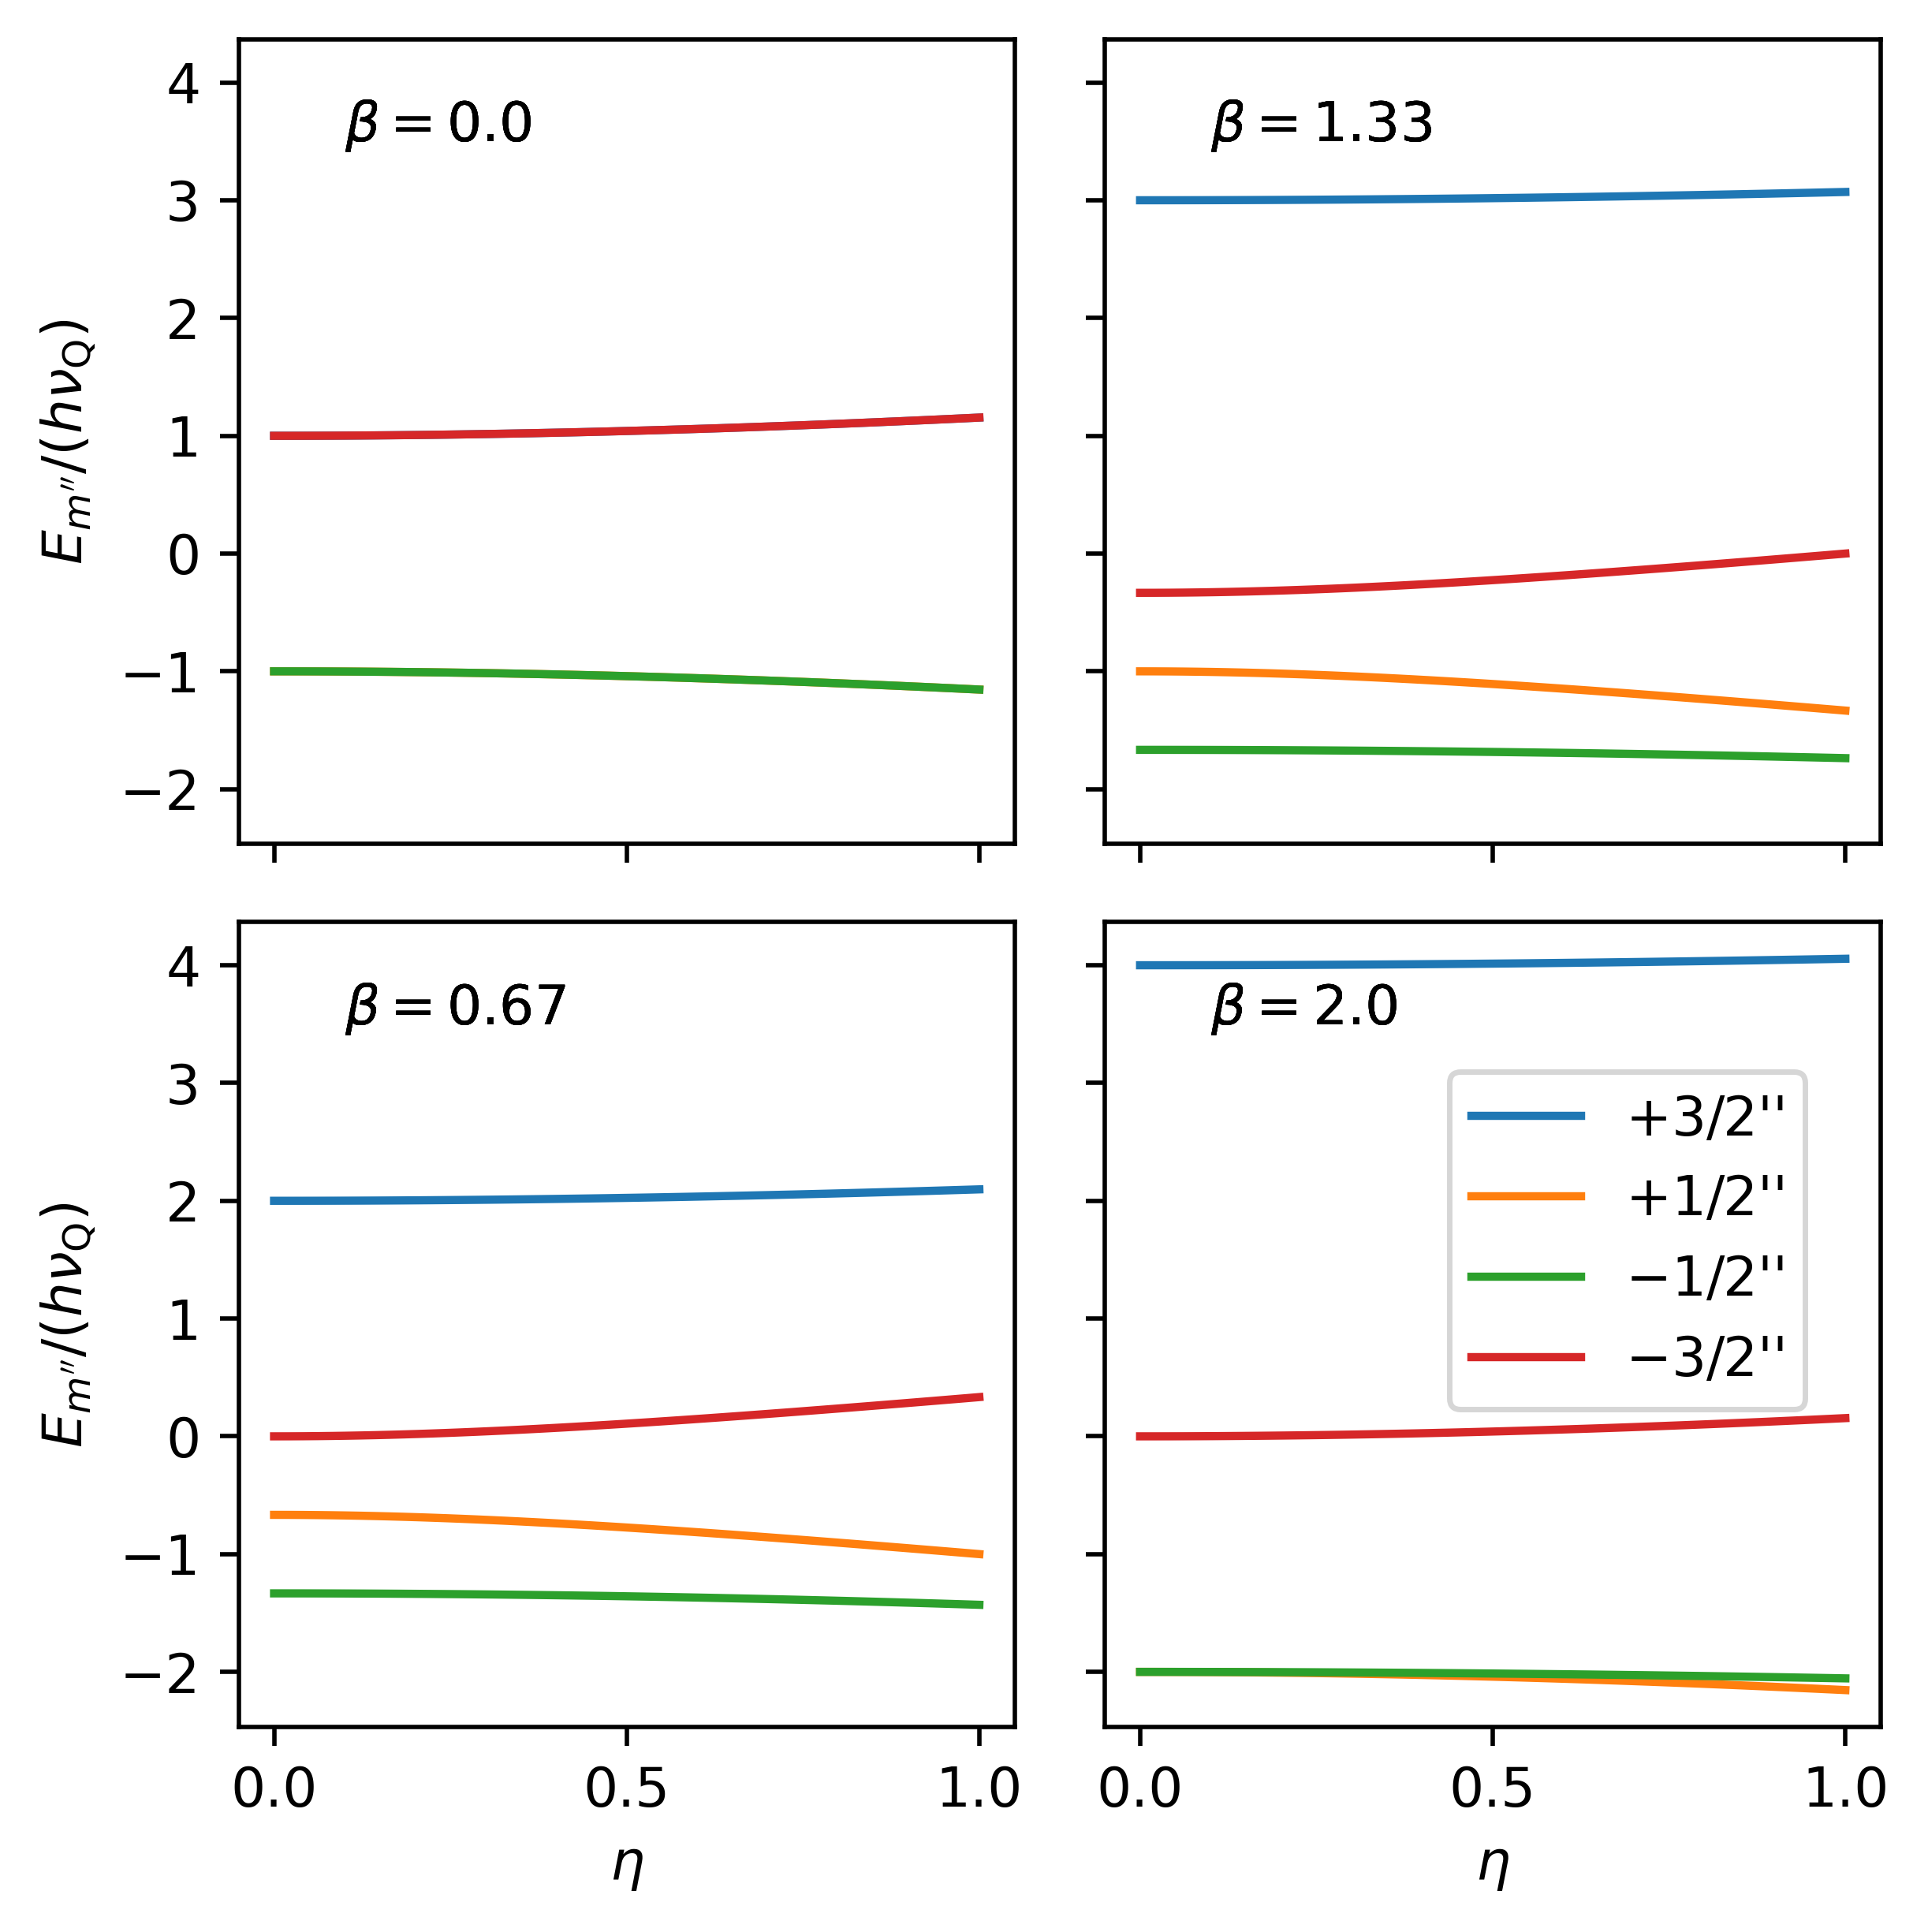

In [207]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5, 5),
                        dpi=500)
                        #gridspec_kw={'hspace': 0,
                        #             'wspace': 0})

beta = np.linspace(0, 2, 4).reshape([2, 2]).T
eta = np.linspace(0, 1)
for i, m in enumerate([r'$' + num + r'/2$' for num in ['+3', '+1', '-1', '-3']]):
    E = sp.lambdify([sym.beta, sym.eta], sym.E[i])
    for j in range(2):
        for k in range(2):
            if j == 1 and k == 1:
                axs[j, k].plot(eta, E(beta[j, k], eta), label=m+"''")
            else:
                axs[j, k].plot(eta, E(beta[j, k], eta))
            axs[j, k].annotate(r'$\beta =' + f'{np.round(beta[j, k], 2)}' + r'$', xy=(0.1, 3.5), xycoords='data')
axs[0, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_xlabel(r"$\eta$")
axs[1, 1].set_xlabel(r"$\eta$")
fig.tight_layout()
axs[1, 1].legend(loc='lower left', bbox_transform=axs[1, 1].transData, bbox_to_anchor=(0.4, 0))
fig.savefig('/Users/jaafar/Documents/school/784phys/final/energy.jpg', bbox_inches='tight')

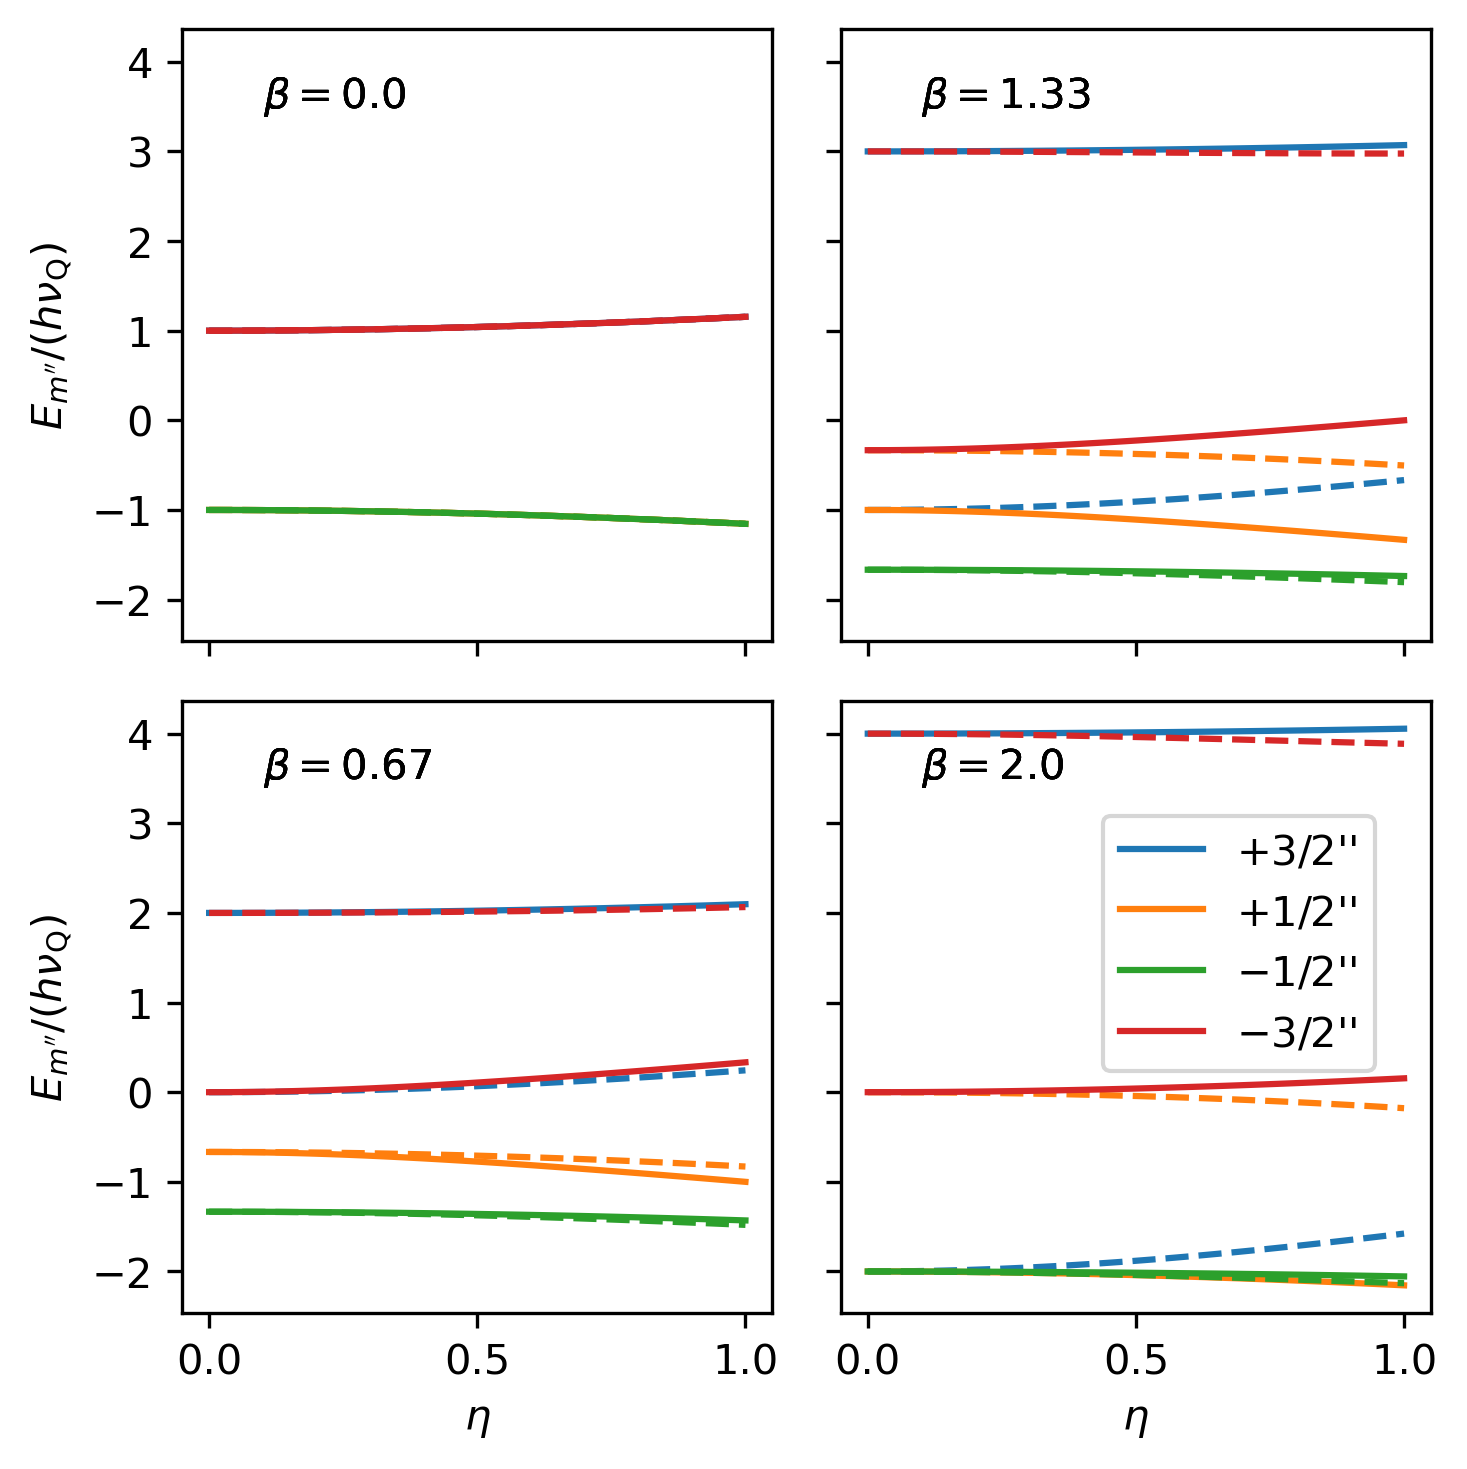

In [12]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5, 5),
                        dpi=300)
                        #gridspec_kw={'hspace': 0,
                        #             'wspace': 0})
rho = sp.sqrt(1 + sym.eta**2/3)
E_pert = {}
E_pert[0] = rho - sym.beta/(2*rho)*(2 + rho)
E_pert[3] = rho + sym.beta/(2*rho)*(2 + rho)
E_pert[2] = -rho - (sym.beta/2*rho)*(2 - rho)
E_pert[1] = -rho + (sym.beta/2*rho)*(2 - rho)
        
beta = np.linspace(0, 2, 4).reshape([2, 2]).T
eta = np.linspace(0, 1)
for i, m in enumerate([r'$' + num + r'/2$' for num in ['+3', '+1', '-1', '-3']]):
    E = sp.lambdify([sym.beta, sym.eta], sym.E[i])
    e = sp.lambdify([sym.beta, sym.eta], E_pert[i])
    for j in range(2):
        for k in range(2):
            if j == 1 and k == 1:
                p = axs[j, k].plot(eta, E(beta[j, k], eta), label=m+"''")
                axs[j, k].plot(eta, e(beta[j, k], eta), '--', color=p[-1].get_color())
            else:
                p = axs[j, k].plot(eta, E(beta[j, k], eta))
                axs[j, k].plot(eta, e(beta[j, k], eta), '--', color=p[-1].get_color())
            axs[j, k].annotate(r'$\beta =' + f'{np.round(beta[j, k], 2)}' + r'$', xy=(0.1, 3.5), xycoords='data')
axs[0, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_xlabel(r"$\eta$")
axs[1, 1].set_xlabel(r"$\eta$")
fig.tight_layout()
axs[1, 1].legend(loc='lower left', bbox_transform=axs[1, 1].transData, bbox_to_anchor=(0.4, 0))
#fig.savefig('/Users/jaafar/Documents/school/784phys/final/energy.jpg', bbox_inches='tight')

## Transition Frequencies

Now we find all allowed transition frequencies (negative ones are excluded).

In [138]:
sym.freqs = {}
trans = [(1, 0), (3, 0), (2, 1), (2, 3), (2, 0), (1, 3)]
for t in trans:
    i, j = t
    sym.freqs[t] = sym.E[j] - sym.E[i]
    print(f'{i} -> {j}')
    display(sym.freqs[(i, j)])
    print('-'*15)

1 -> 0


beta + sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
3 -> 0


beta - sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
2 -> 1


-beta - sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
2 -> 3


-beta + sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
2 -> 0


2*sqrt(eta**2/3 + (beta + 1)**2)

---------------
1 -> 3


2*sqrt(eta**2/3 + (beta - 1)**2)

---------------


$+3/2''$ $+1/2''$
$+3/2''$ $-3/2''$
$+1/2''$ $-1/2''$
$-3/2''$ $-1/2''$
$+3/2''$ $-1/2''$
$-3/2''$ $+1/2''$


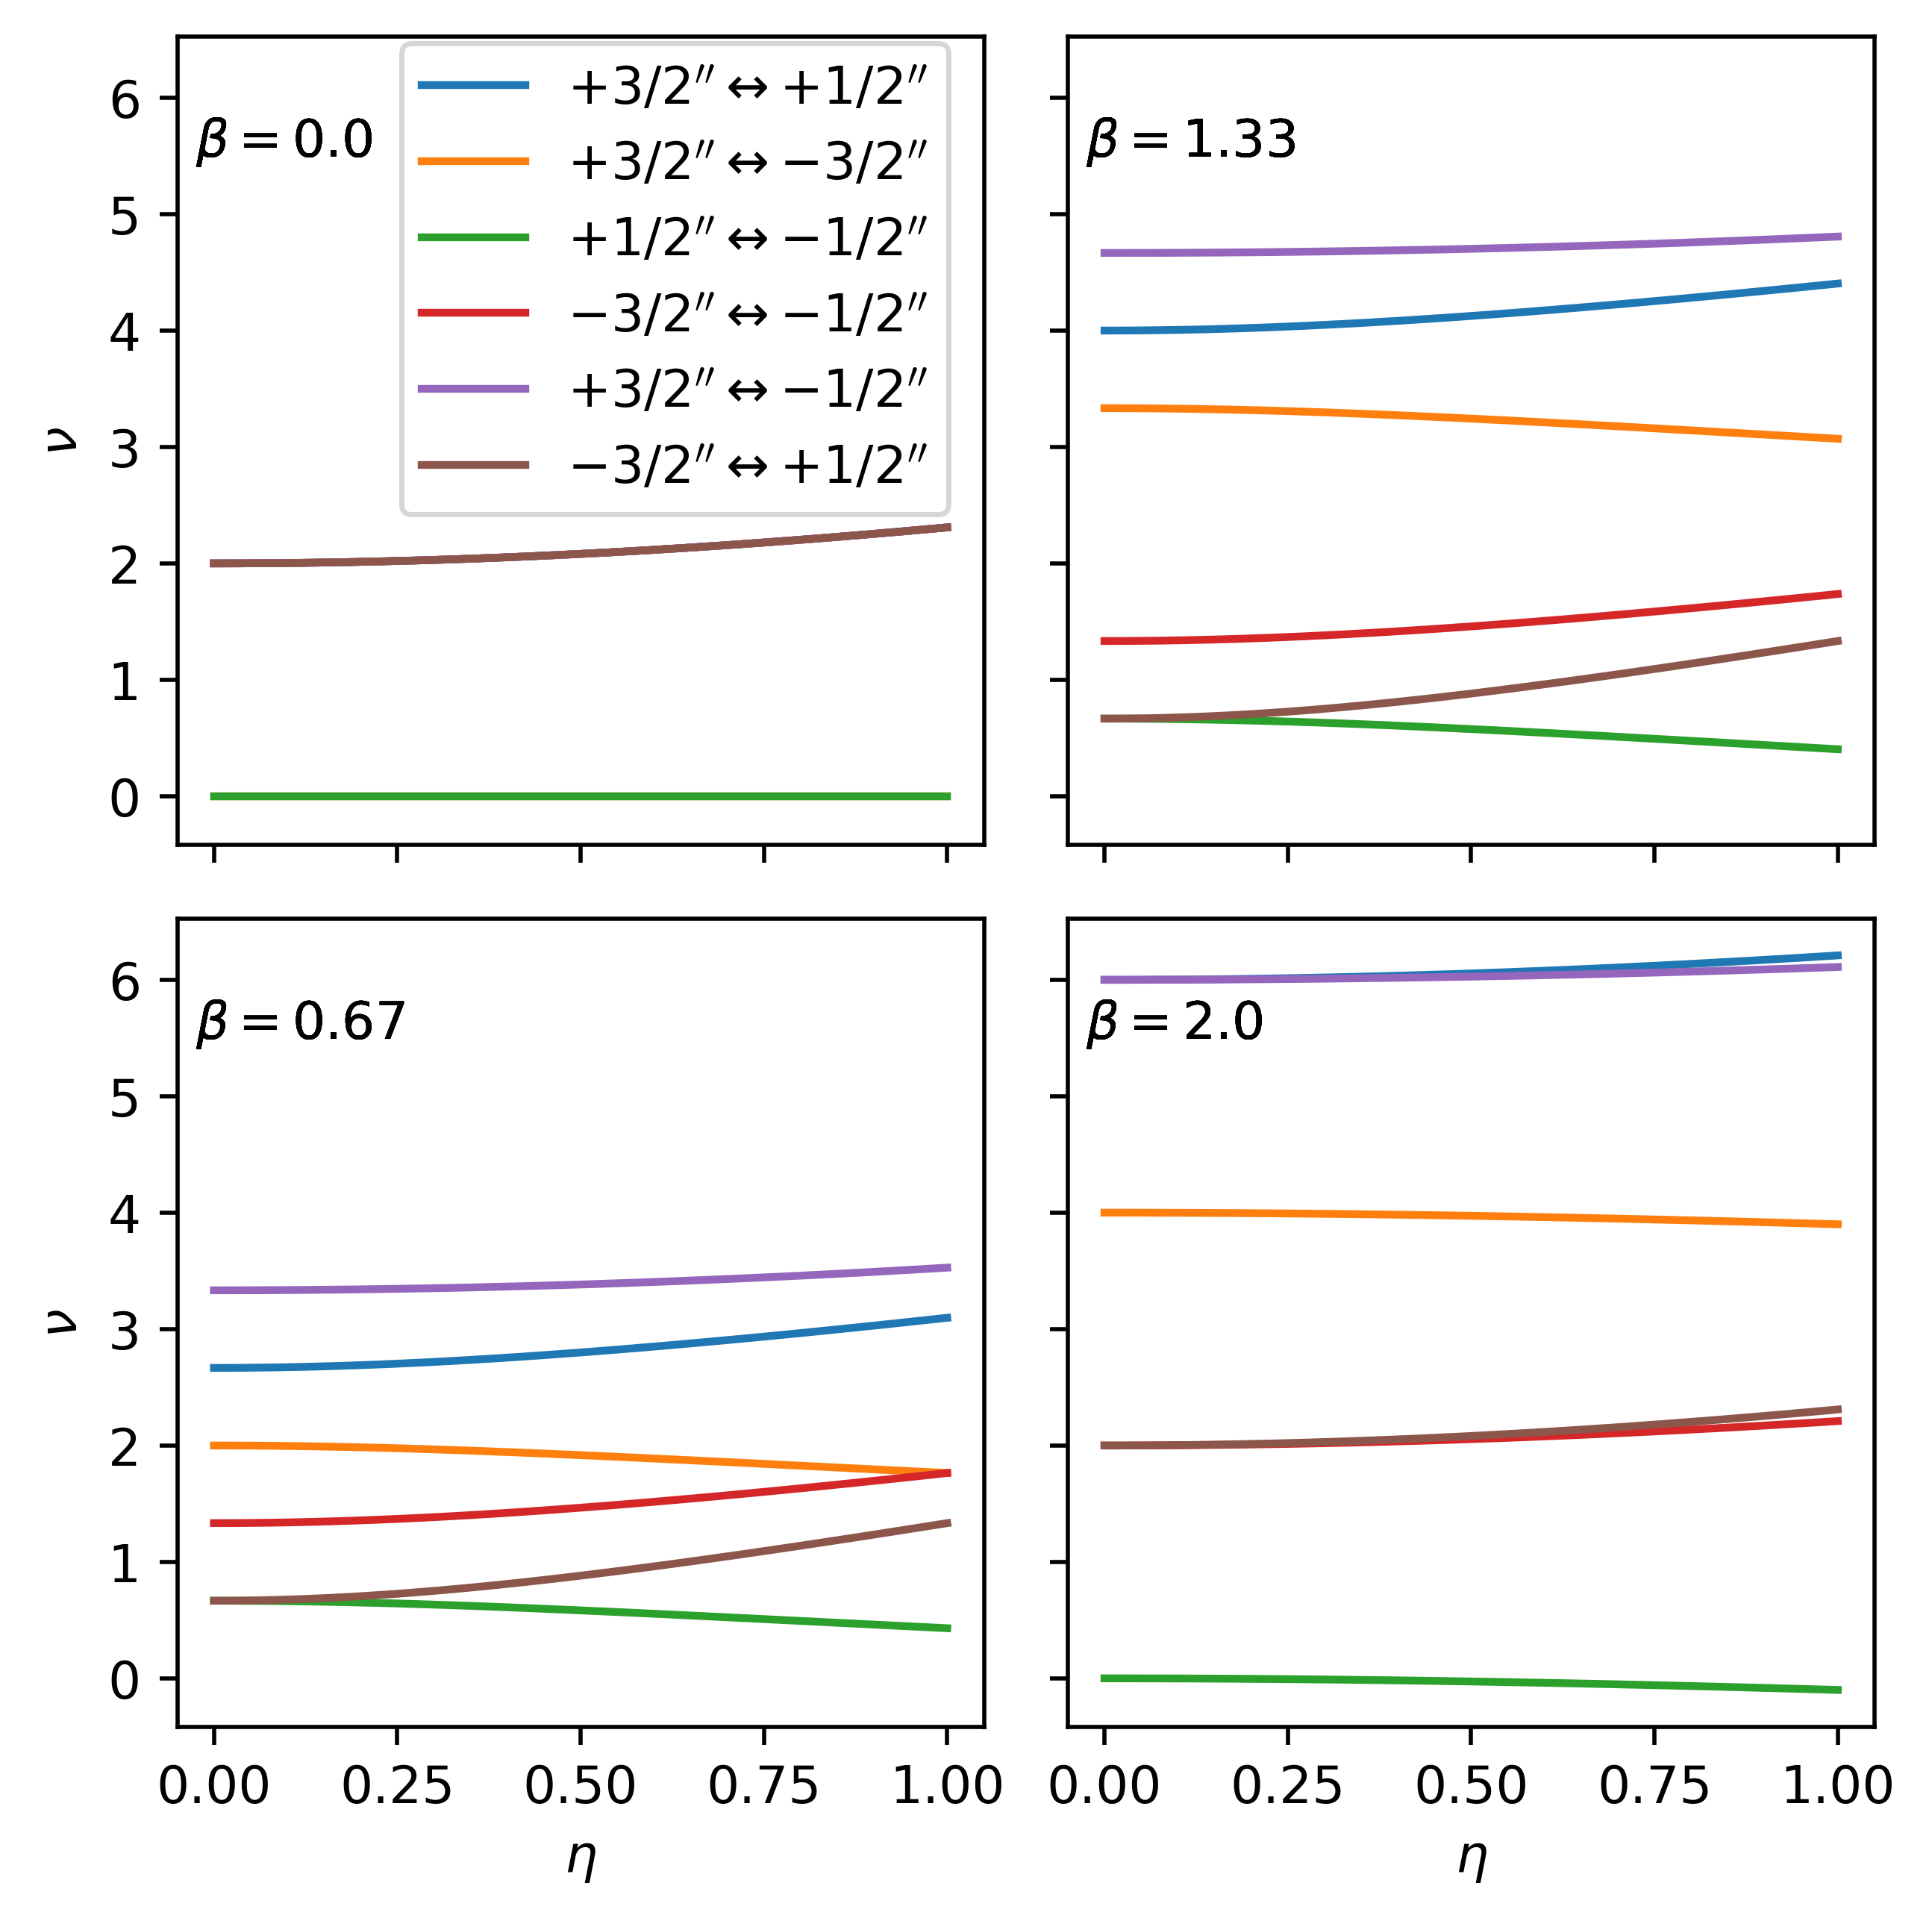

In [205]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5.25, 5.25),
                        dpi=500)
                        #gridspec_kw={'hspace': 0,
                        #             'wspace': 0})

beta = np.linspace(0, 2, 4).reshape([2, 2]).T
eta = np.linspace(0, 1)
t_labels = {0: r"$+3/2''$", 1: r"$+1/2''$", 2: r"$-1/2''$", 3: r"$-3/2''$"}
for t in sym.freqs:#i, m in enumerate([r'$' + num + r'/2$' for num in ['+3', '+1', '-1', '-3']]):
    p, q = t
    print(t_labels[q], t_labels[p])
    v = sp.lambdify([sym.beta, sym.eta], sym.freqs[t])
    for j in range(2):
        for k in range(2):
            if (j, k) == (0, 0):
                axs[j, k].plot(eta, v(beta[j, k], eta), label=t_labels[q] + r'$\leftrightarrow$' + t_labels[p])
            else:
                axs[j, k].plot(eta, v(beta[j, k], eta))
            axs[j, k].annotate(r'$\beta =' + f'{np.round(beta[j, k], 2)}' + r'$', xy=(-0.025, 5.5), xycoords='data')
            #axs[j, k].set_ylim(0, 6.5)
axs[0, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_xlabel(r"$\eta$")
axs[1, 1].set_xlabel(r"$\eta$")
fig.tight_layout()
axs[0, 0].legend(loc='lower left', bbox_transform=axs[0, 0].transData, bbox_to_anchor=(0.22, 2.2))
fig.savefig('/Users/jaafar/Documents/school/784phys/final/freqs.jpg', bbox_inches='tight')

Some of these transitions will be weaker than others, so we calculate the magnetic moment of each frequency to determine its intensity. We first create Python lambda functions that we can use to store the magnetic moment expressions and treat as Python functions.

In [151]:
sym.mat = {}
sym.mat['x'] = {}#sp.Matrix(np.zeros((4, 4)))
sym.mat['y'] = {}#sp.Matrix(np.zeros((4, 4)))
sym.mat['z'] = {}#sp.Matrix(np.zeros((4, 4)))
for d in ['x', 'y', 'z']:
    for i, tran in enumerate(sym.freqs):
        p, q = tran
        Xp, Xq = sym.V[p], sym.V[q]
        wpq = sym.freqs[tran]
        mat = sp.simplify(Xp.T*sym.I[d]*Xq)
        sym.mat[d][tran] = sp.lambdify([sym.beta, sym.eta], mat.subs(EVSUBS))

With the functions defined, we can now visualize the spectrum.

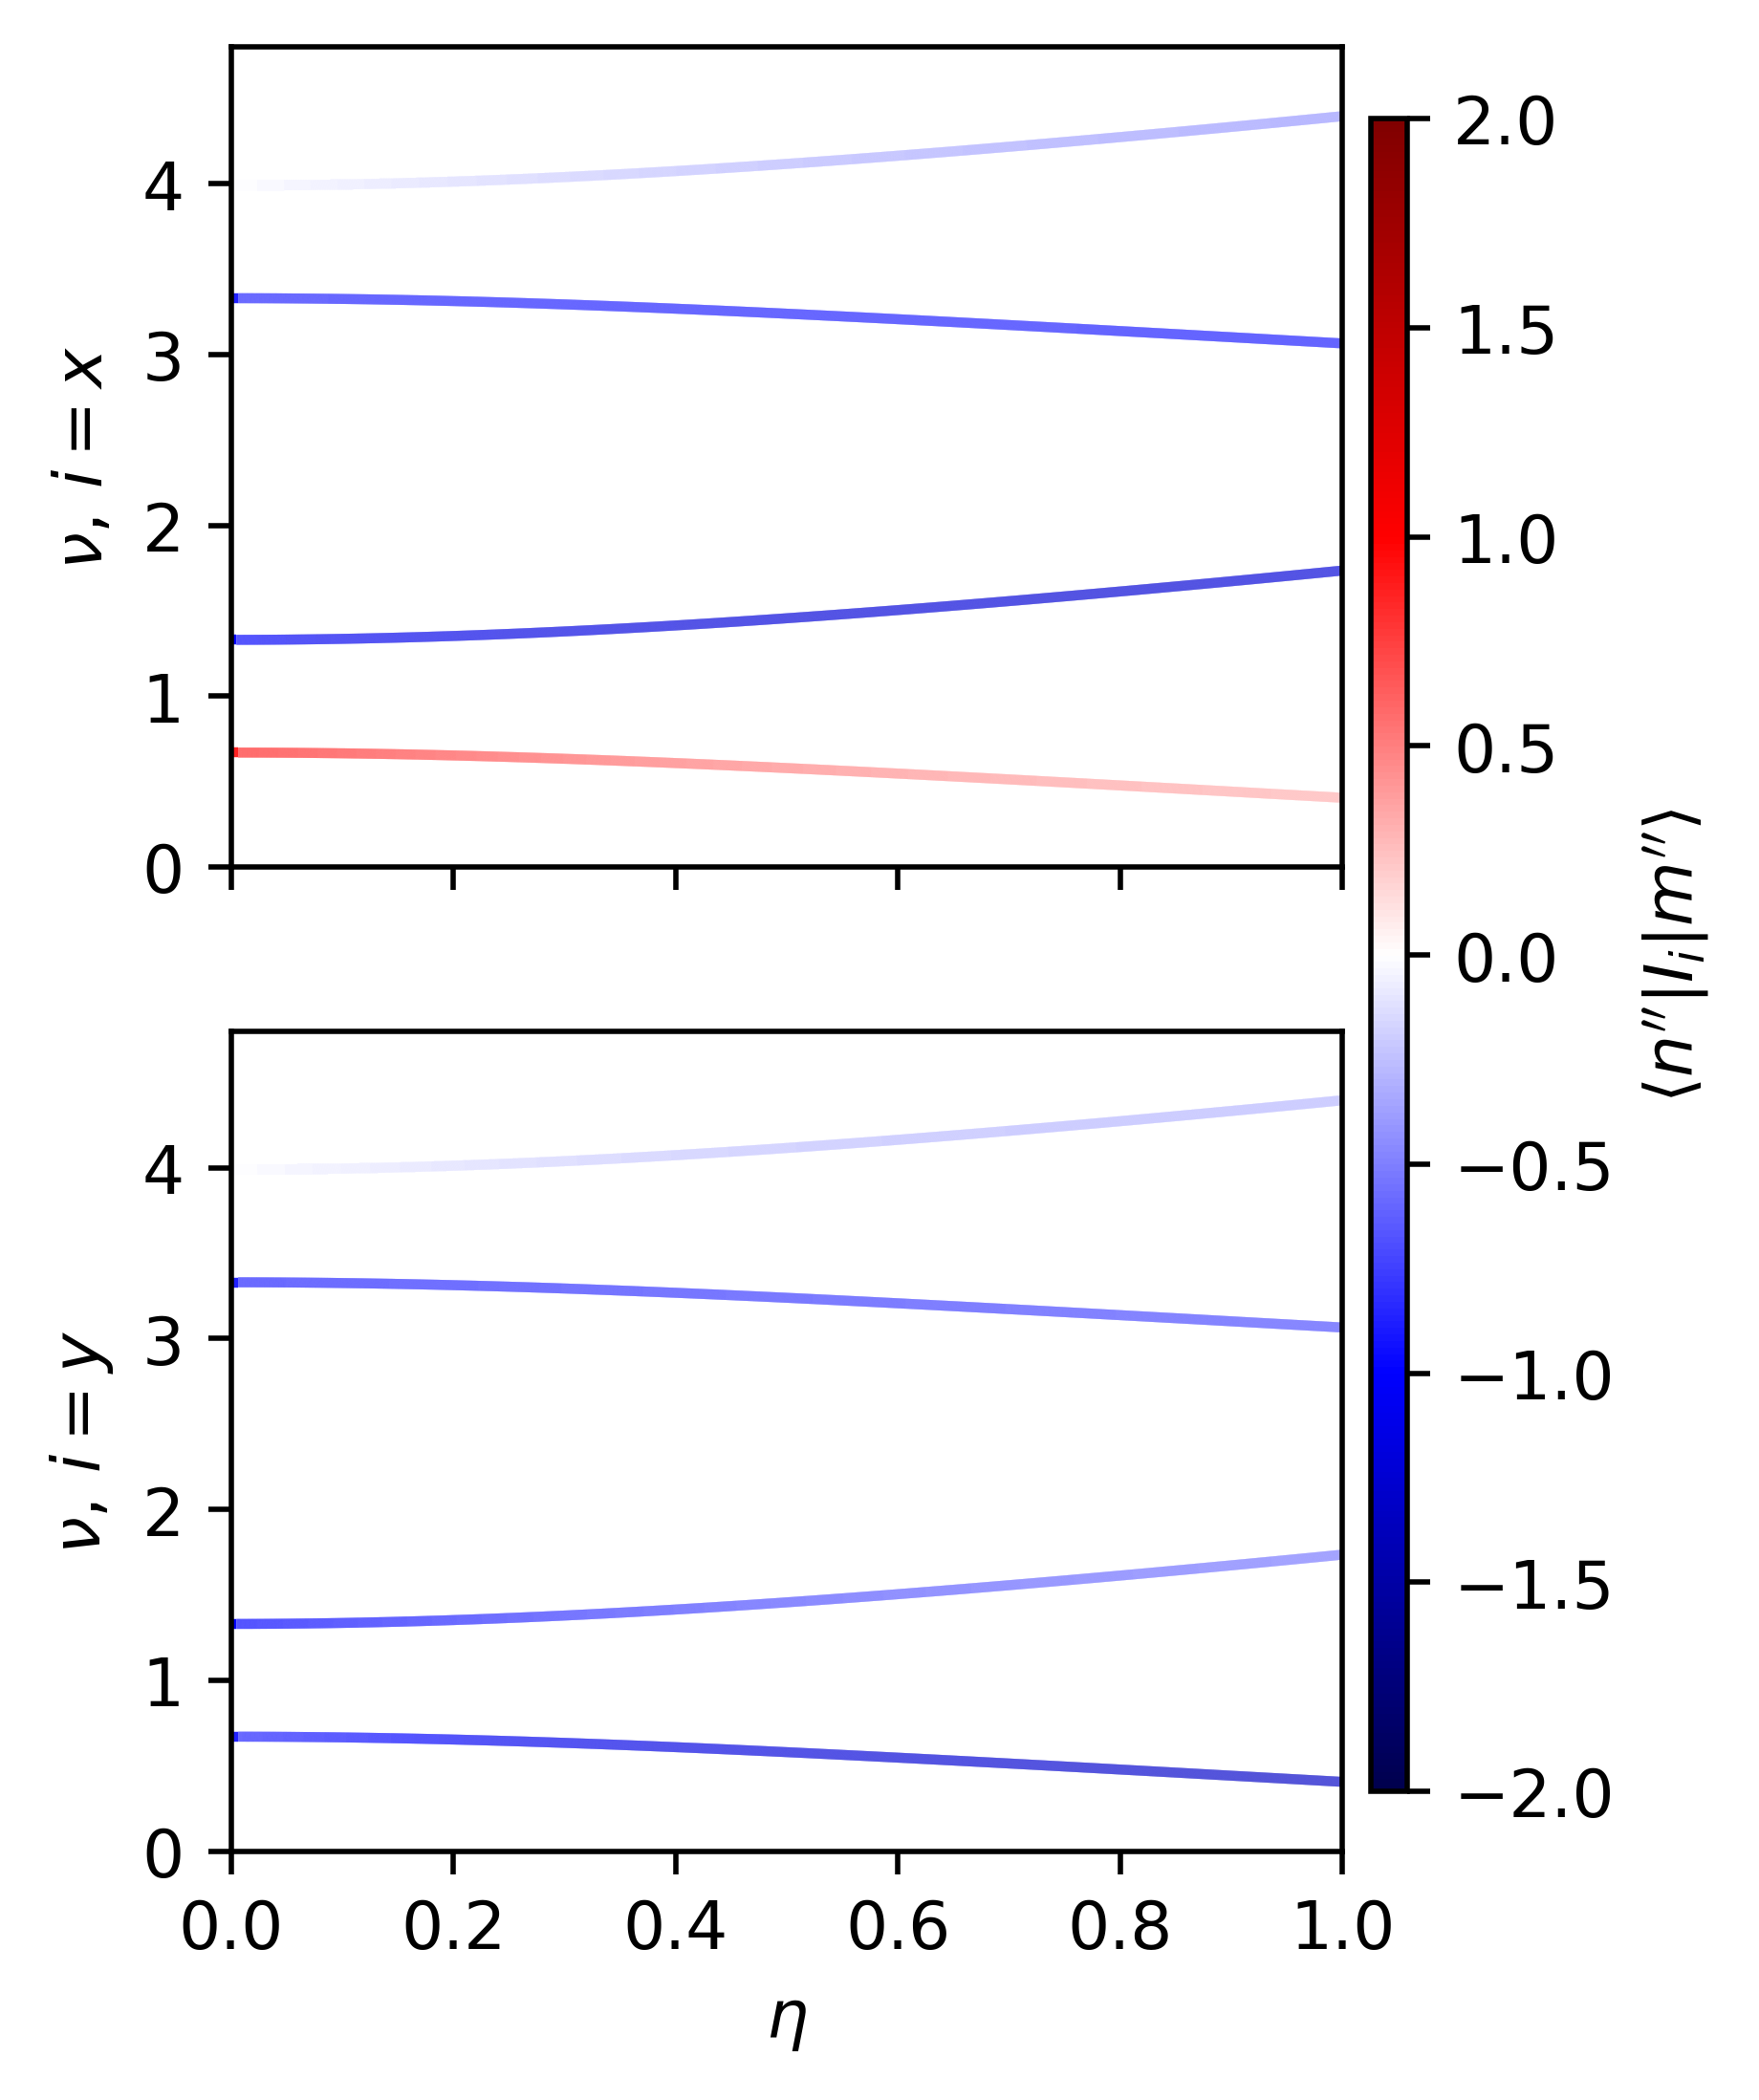

In [210]:
eta = np.linspace(0, 1, 10000)[1:]
beta = 1.33#np.linspace(0, 1.5, 100)
xdata = {}
ydata = {}
cdata = {}
for i, d in enumerate(['x', 'y']):
    mat = sym.mat[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(mat):
        p, q = tran
        wpq = sp.lambdify([sym.beta, sym.eta], sym.freqs[tran].subs(EVSUBS))(beta, eta)
        x = eta.copy()#[wpq >= 0]
        y = wpq.copy()#[wpq >= 0]
        _mat = mat[tran](beta, eta).squeeze()
        if np.any(_mat != 0):
            c = _mat#[wpq >= 0]
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c).copy()
        else:
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = np.zeros(eta.size)

# mpl.style.use('default')
fig, ax = plt.subplots(2,#nrows=2, ncols=2,
                       sharex=True,
                       sharey=True,
                      # gridspec_kw = {'hspace': 0.12, 'wspace': 0.15},
                       figsize=(3, 5),#FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=500)
cmin, cmax = -2, 2
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            _cmax, _cmin = find_max_min([func[k](c) for c in cdata_list])
            if _cmax > cmax:
                cmax = _cmax
            if _cmin < cmin:
                cmin = _cmin
cmin, cmax = -2, 2#-1.67, 1.67#0.05/1000
#ymin, ymax = 0, 4
for i, d in enumerate(['x', 'y']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    ymax, ymin = find_max_min(ydata_list)
    norm = plt.Normalize(cmin, cmax)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        y = ydata[d][tran]
        #for k in [0, 1]:
        func = {0: np.real, 1: np.imag}
        if d == 'x':
            c = func[0](cdata[d][tran])
        else:
            c = func[1](cdata[d][tran])
        if np.all(np.isclose(c, np.zeros(c.size))):
            continue
        points = np.array([x, y], dtype=object).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mpl.collections.LineCollection(segments, cmap='seismic', norm=norm)
        lc.set_array(c)
        line = ax[i].add_collection(lc)
        ax[i].set_xlim(0, 1)
        ax[i].set_ylim(0, ymax)
        ax[i].set_facecolor("white")
#             ax[i, k].text(0.3, 3.2,
#                        r"$i = " + d + "$",
#                        color='k',
#                        horizontalalignment='center',
#                        verticalalignment='center',
#                        transform=ax[i][k].transData)
        ax[-1].set_xlabel(r'$\eta$')
        ax[i].set_ylabel(r"$ \nu,\, i = " + d + "$")
# D_label = sp.nsimplify(D, constants=[sp.pi])
# if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
# else:
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(line, cax=cbar_ax)#ax[:, 2], location='right')#, shrink=0.6)
#fig.tight_layout()
cbar.set_label(r"$\langle n''| I_i |m''\rangle$")#/(E_{m''} - E_{n''})$")
fig.savefig('/Users/jaafar/Documents/school/784phys/final/mats.jpg', bbox_inches='tight')

In [ ]:
sym.E = [sym.eig[i][0] for i in range(4)]
sym.V = [None]*4
sym.V[0] = sym.eig[0][2][0]
sym.V[1] = sym.eig[1][2][0]*-sym.s/(sym.ap + sp.sqrt(sym.ap**2 + sym.s**2))
sym.V[2] = sym.eig[2][2][0]*-sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
sym.V[3] = sym.eig[3][2][0]*sym.s/(-sym.am + sp.sqrt(sym.am**2 + sym.s**2))*sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
_E, _V = ([None]*len(sym.V) for i in range(2))
sym.subs = {sym.ap: sym.alpha + sp.cos(sym.D), sym.am: sym.alpha - sp.cos(sym.D), sym.s: sp.sin(sym.D)}
for i in range(4):
    sym.E[i] = sym.E[i]
    sym.V[i] = sp.simplify(sym.V[i])#.subs(sym.subs).subs(sym.D, 0)
    display(sym.E[i], sym.V[i])
sym.E[2] = -sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.E[3] = sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.V[2] = sp.Matrix([0, 1, 0, -sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2))])
sym.V[3] = sp.Matrix([0, sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2)), 0, 1])

In [ ]:
for i in range(4):
    display(sym.E[i], sym.V[i])#.subs(sym.subs))#.subs(sym.D, 0))

In [ ]:
mpl.style.use('seaborn')
mpl.style.use('seaborn-bright')
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6/2/2#/10#np.sin(0)
num_subs = {sym.alpha: alpha, sym.D: D}
fig, ax = plt.subplots(2,
                       sharex=True,
                       dpi=400,
                       gridspec_kw={'hspace':0.01},
                       figsize=(FIGSIZE[0]/1.6, FIGSIZE[1]))
sym.EV = {}
sym.EV_norm = {}
for i in range(4):
    for j, e in enumerate(sym.V[i]):
        if e == 1:
            label = str(sp.nsimplify(np.arange(I, -I - 1, -1)[j]))
            sym.EV[label] = (sym.E[i], sym.V[i])
    E, V = sym.EV[label]
    norm = 1/sp.sqrt(V.dot(V))
    V_norm = sp.trigsimp(norm*V)
    sym.EV_norm[label] = (E, V_norm)
    y = sp.lambdify([sym.alpha, sym.D], E.subs(sym.subs))(alpha, D)
    y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
    ax[0].plot(alpha, y, label=f"{label}''")
sym.f = {}
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'midnightblue', 'lawngreen', 'teal', 'thistle']
color_i = 0
for p in sym.EV:
    for q in sym.EV:
        Ep = sym.EV[p][0]
        Eq = sym.EV[q][0]
        f = Eq - Ep
        y = sp.lambdify([sym.alpha, sym.D], f.subs(sym.subs))(alpha, D)
        if type(y) == int and y == 0:
            pass
        else:
            x = alpha[y >= 0]
            y = y[y >= 0]
            if y.size > 0:
                sym.f[(p, q)] = f
                y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
                ax[1].plot(x, y, label=f"{p}'' --> {q}''", c=colors[color_i])
                color_i += 1
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.p >= 100 or D_label.q >= 100:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$E_{m''} - E_{n''}$")
ax[0].set_ylabel(r"$E_{m''}$")
ax[0].legend()
ax[1].legend(loc=(1, 0.1))
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'energy_trans.jpg'), bbox_inches='tight')

In [ ]:
# sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
# sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
# sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
# sym.Iexp = {}
# sym.Iexp['x'] = {}
# sym.Iexp['y'] = {}
# sym.Iexp['z'] = {}
# V10 = sp.Matrix([1, 0])
# V01 = sp.Matrix([0, 1])
# c = [None]*3
# c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
# c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
# c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
# beta = {}
# beta['x'] = sp.Matrix(np.zeros((4, 4)))
# beta['y'] = sp.Matrix(np.zeros((4, 4)))
# beta['z'] = sp.Matrix(np.zeros((4, 4)))
# for xyz in ['x', 'y', 'z']:
#     for i, p in enumerate(sym.V_mbasis):
#         for j, q in enumerate(sym.V_mbasis):
#             Ep, Eq = sym.EV[p][0], sym.EV[q][0]
#             (Vp, normp), (Vq, normq) = sym.V_mbasis[p], sym.V_mbasis[q]
#             wpq = Eq - Ep
#             norm = sp.simplify(normp*normq)
#             beta[xyz][i, j] = 4*Vp.dot(sym.I[xyz]*Vq)
# for i, p in enumerate(sym.V_mbasis):
#     for j, q in enumerate(sym.V_mbasis):
#         compi, compj = 0, 0
#         for m, xyz in enumerate(['x', 'y', 'z']):
#             betam = beta[xyz][i, j]
#             compi += c[m]*sp.re(betam)
#             compj += c[m]*sp.im(betam)
#         norm = sp.sqrt(compi**2 + compj**2)
#         if norm != 0:
#             nhat = sp.Matrix([compi, compj, 0])/norm
#             mid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
#             factor = sp.simplify((V01.T*mid*V10)[0])
#             display(factor)
#             _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
#             Iexp = _Iexp# + sp.conjugate(_Iexp)
#             sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# Warning: this cell takes about 1-2 minutes to run
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
V10 = sp.Matrix([1, 0])
V01 = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
for xyz in ['x', 'y', 'z']:
    for p in sym.EV:
        for q in sym.EV:
            Ep, Eq = sym.EV[p][0], sym.EV[q][0]
            Vp, Vq = sym.EV[p][1], sym.EV[q][1]
            wpq = Eq - Ep
            beta = Vp.dot(sym.I[xyz]*Vq)
            compi, compj = 0, 0
            for m, xyz2 in enumerate(['x', 'y', 'z']):
                betam = Vp.dot(sym.I[xyz2]*Vq)
                compi += c[m]*sp.re(betam)
                compj += c[m]*sp.im(betam)
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp# + sp.conjugate(_Iexp)
            sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# # Run above cell before running this one if it has been a while...
# mpl.style.use('seaborn')
# alpha = np.linspace(0, 1.5, 5000)[1:]
# D = np.pi/24#/10#np.sin(0)
# fig, ax = [None]*3, [None]*3
# fig[0], ax[0] = plt.subplots(1, dpi=150)
# fig[1], ax[1] = plt.subplots(1, dpi=150)
# fig[2], ax[2] = plt.subplots(1, dpi=150)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
# color_i = 0
# for i, xyz in enumerate(['x', 'y', 'z']):
#     Iexp = sym.Iexp[xyz]
#     for j, tran in enumerate(Iexp):
#         p, q = tran
#         y = Iexp[tran](alpha, D)# + np.conjugate(Iexp[tran](alpha, D))
#         #print(y, type(y))
#         cond = type(y) == int and y == 0\
#                or type(y) == float\
#                or type(y) == np.float64 or np.all(np.isclose(y, np.zeros(alpha.size)))
#         if cond:
#             pass
#         else:
#             y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
#             ax[i].plot(alpha, np.real(y), label=f"{p}'' --> {q}''", color=colors[color_i])
#             color_i += 1
#     ax[i].set_ylabel(r'$\langle I_' + xyz + r'\rangle$ $(\hbar/kT)$')
#     ax[i].legend()
#     ax[i].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(sp.nsimplify(D, constants=[sp.pi]), fold_short_frac=True)}$');

In [ ]:
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6
xdata = {}
ydata = {}
cdata = {}
xyz_data_labels = []
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    xdata[xyz] = {}
    ydata[xyz] = {}
    cdata[xyz] = {}
    for j, t in enumerate(Iexp):
        p, q = t
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        f = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))
        y = f(alpha, D)
        c = Iexp[t](alpha, D, 0)
        if not np.all(np.isclose(np.imag(c), np.zeros(alpha.size))):
            pass#c = np.imag(c)
        else:
            c = np.real(c)
        cond = type(y) == int and y == 0\
               or type(c) == int and c == 0\
               or type(c) == float\
               or np.all(np.isclose(c, np.zeros(alpha.size)))
        if cond:
            pass
        else:
            x = alpha[y >= 0]
            c = c[y >= 0]
            y = y[y >= 0]
            if y.size == 0:
                pass
            else:
                y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
                xdata[xyz][t] = x
                ydata[xyz][t] = y
                cdata[xyz][t] = c
    if list(cdata[xyz].values()) != []:
        xyz_data_labels.append(xyz)

mpl.style.use('default')
fig, ax = plt.subplots(len(xyz_data_labels),
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=450)
cmin, cmax = 100, 0
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        _cmax, _cmin = find_max_min([np.abs(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        ymax, ymin = find_max_min(ydata_list)
        norm = plt.Normalize(cmin, cmax)
        for j, t in enumerate(cdata[xyz]):
            x = xdata[xyz][t]
            y = ydata[xyz][t]
            c = np.abs(cdata[xyz][t])/cmax/y
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='hot', norm=norm)
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax[i].add_collection(lc)
        ax[i].set_xlim(alpha.min(), alpha.max())
        ax[i].set_ylim(ymin, ymax)
        ax[i].set_ylabel(r"$ E_{m''} - E_{n''}$")
        ax[i].set_facecolor("black")
        ax[i].text(0.1, 0.9,
                   r"$i = " + xyz + "$",
                   color='w',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
cbar = fig.colorbar(line, ax=ax[0:], location='right')#, shrink=0.6)
cbar.set_label(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
alpha = 100
D = 0.01
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=200)
data = {}
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    data[xyz] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        w = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))(alpha, D)
        cond1 = w != 0 and w > 0
        if cond1:
            t = np.linspace(0, 2*np.pi)/w
            y = Iexp[tran](alpha, D, t)
            cond2 = (type(y) == float and np.isnan(y)) or (type(y) == int)
            if cond2:
                pass
            else:
                data[xyz][tran] = (y, w, t)
                #p = ax[i].plot(t*wpq, np.real(y))
                #ax[i].plot(t*wpq, np.imag(y), '.', c=p[-1].get_color())
for i, tran in enumerate(data['x']):
    Ix, wx, tx = data['x'][tran]
    Iy, wy, ty = data['y'][tran]
    Itot = Ix*np.cos(wx*tx) + Iy*np.sin(wy*ty)
    px = ax[0].plot(tx*wx, np.real(Ix))
    py = ax[1].plot(ty*wy, np.real(Iy))
    ptot = ax[2].plot(tx*wx, np.real(Itot))
    ax[0].plot(tx*wx, np.imag(Ix), '-.', c=px[-1].get_color())        
    ax[1].plot(ty*wy, np.imag(Iy), '-.', c=py[-1].get_color())
    ax[2].plot(tx*wx, np.imag(Itot), '-.', c=ptot[-1].get_color())
    
ax[-1].set_xlabel(r'$ \omega t $')
ax[0].set_ylabel(r'$ I_x $')
ax[1].set_ylabel(r'$ I_y $')

# Parameters

In [ ]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
sym.x, sym.y, sym.p1, sym.p2, sym.r, sym.wt = sp.symbols(r'x y p_1 p_2 r \tilde{w}_2', real=True)
sym.p1, sym.p2, sym.p3, sym.p4, sym.p5, sym.p6 = sp.symbols('p_1 p_2 p_3 p_4 p_5 p_6', real=True)
f1 =  sym.p1 + sym.p2*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p3*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
f2 =  sym.p4 + sym.p5*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p6*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1/f2 - sym.w1/sym.w2
exp2 = sym.wi*f2 - sym.w2
sol = sp.nonlinsolve([exp1.subs(subs), exp2.subs(subs)], [sym.x, sym.y])
xy_sol = list(sol)[0]
display(exp1, exp2, xy_sol)

In [ ]:
sym.c1, sym.c2 = sp.symbols('c_1 c_2', real=True)
x, y = xy_sol
exp1 = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2) + sym.c1
exp2 = sp.sqrt(sym.ap**2 + sym.s**2) - sym.c2
as_sol = sp.solve([exp1, exp2], [sym.ap, sym.am])
display(exp1, exp2, as_sol[0], as_sol[1])

In [ ]:
J = sp.symbols('J', real=True)
subs = {sym.s: sp.sin(sym.D)}
exp1 = ((sym.alpha + sp.cos(sym.D))**2 - as_sol[1][0]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
exp2 = ((sym.alpha - sp.cos(sym.D))**2 - as_sol[1][1]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
#sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]).simplify()
sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, J]).simplify()
display(exp1, exp2, sol)

In [ ]:
def get_c(w1, w2, wi, _p1, _p2):
    p1, p2, p3 = tuple(_p1)
    p4, p5, p6 = tuple(_p2)
    
    den = wi*(p2*p6 - p3*p5)
    c1_num = w1*p5 - w2*p2 + wi*(p2*p4 - p1*p5)
    c2_num = w1*p6 - w2*p3 + wi*(p3*p4 - p1*p6)

    if den == 0:
        return np.inf, np.inf
    else:
        return c1_num/den, c2_num/den

v = [None]*3
v[0] = sym.s
v[1] = sp.sqrt(sym.ap**2 + sym.s**2)
v[2] = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
w1 = 11.7*mega
w2 = w1 + 8.8*mega
wi = 1.6*7.292*mega
for t1 in sym.f:
    for t2 in sym.f:
        f1 = sym.f[t1]
        f2 = sym.f[t2]
        p1, p2 = (np.zeros(3) for i in range(2))
        for i in range(3):
            n = 1
            if i == 0:
                n = 0
            p1[i], p2[i] = (f1.as_expr().coeff(v[i], n), f2.as_expr().coeff(v[i], n))
        c1, c2 = get_c(w1, w2, wi, p1, p2)
        if not np.all([np.isfinite(val) for val in [c1, c2]]):
            continue
        if c1**2 + c2**2 - 2 < 0:
            continue
        factor = np.sqrt(2*(c1**2 + c2**2 - 2))
        alpha = factor/2 
        cosD = (c1**2 - c2**2)/2/factor
        if cosD > 1 or -cosD > 1:
            continue
        cosD = np.abs(cosD)
        D = np.arccos(cosD)
        subs = {sym.alpha: alpha, sym.D: D}
        f1_val = np.float(f1.subs(sym.subs).subs(subs).evalf())
        f2_val = np.float(f2.subs(sym.subs).subs(subs).evalf())
        Iexp_t1 = np.real(sym.Iexp['y'][t1](alpha, D))
        Iexp_t2 = np.real(sym.Iexp['y'][t2](alpha, D))
        if not np.isclose([f1_val/f2_val], [w1/w2]) or np.any(np.isnan([Iexp_t1, Iexp_t2])):
            continue
        if D > np.pi/6:
            continue
        print('trans: ', t1, t2)
        print("params: ", alpha, cosD)
        print("freqs: ", f1_val, f2_val)
        print("checks: ", wi*f1_val, w1, f1_val/f2_val, w1/w2, wi*f2_val, w2)
        print('-'*80)

In [ ]:
from scipy.constants import h, hbar, e
I = 3/2
gamma = 7.315021*mega
Bi = 1.60
Q = nmr.get_Q('As', 75).n
wi = gamma*Bi
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*Q*(4*I*(2*I - 1)*h)/(3*e*Q)
etanp.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = w = np.sqrt((rho**2 - 1)*3)
Bi, gamma, wi, Q, wQ, Vzz, eta